# **Install Required Libraries**

In [1]:
!pip install emoji transformers datasets evaluate
import re
import emoji
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from pathlib import Path
from collections import Counter
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    pipeline
)
import evaluate
import torch



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2

# **Constants & Regex**

In [3]:
# ───────────────────────────────────────────────────────────────────────
# 0) Constants & Regex
# ───────────────────────────────────────────────────────────────────────
BASE    = Path("/content/drive/MyDrive/stance-20250508T001453Z-1-001/stance" ) # adjust if needed
TOPICS  = ["abortion","atheism","climate","feminist","hillary"]
URL_RE  = re.compile(r"https?://\S+|www\.\S+")
USER_RE = re.compile(r"@\w+")
RT_RE   = re.compile(r"^RT\s+@\w+:\s*")            # retweet prefix

# **Load raw tweets into a DataFrame**

In [4]:
# ───────────────────────────────────────────────────────────────────────
# 1) Load raw tweets into a DataFrame
# ───────────────────────────────────────────────────────────────────────
rows = []
for topic in TOPICS:
    d = BASE / topic
    for split in ["train","val","test"]:
        texts = (d/f"{split}_text.txt").read_text(encoding="utf8").splitlines()
        labels= (d/f"{split}_labels.txt").read_text(encoding="utf8").splitlines()
        for t, l in zip(texts, labels):
            rows.append({
                "topic": topic,
                "split": split,
                "raw_text": t,
                "label": int(l)
            })
df_raw = pd.DataFrame(rows)
print(df_raw.head())

      topic  split                                           raw_text  label
0  abortion  train  we remind ourselves that love means to be will...      1
1  abortion  train  @user @user and most Islanders have different ...      0
2  abortion  train  Life is #precious & so are babies, mothers, & ...      1
3  abortion  train  @user too many people are taking this to serio...      0
4  abortion  train  Dude i won a #freeshirt from @user ! I never w...      0


# **Top 10 hashtags**

In [5]:
# ───────────────────────────────────────────────────────────────────────
# 2) Top 10 hashtags
# ───────────────────────────────────────────────────────────────────────
all_hashtags = []
for txt in df_raw["raw_text"]:
    all_hashtags += re.findall(r"#\w+", txt.lower())
print("Top 10 hashtags (raw):")
for tag, cnt in Counter(all_hashtags).most_common(10):
    print(f"{tag}: {cnt}")

Top 10 hashtags (raw):
#semst: 4063
#god: 76
#gamergate: 74
#tcot: 69
#wakeupamerica: 54
#hillaryclinton: 52
#lovewins: 49
#feminist: 45
#scotus: 38
#prolifeyouth: 37


# **Text Cleaning**

In [6]:
# ───────────────────────────────────────────────────────────────────────
# 3) Define cleaning function (once #SemST,retweet prefix are identified as noise through error analysis)
# ───────────────────────────────────────────────────────────────────────
def clean_text(text: str) -> str:
    text = RT_RE.sub("", text)
    text = URL_RE.sub(" <URL> ", text)
    text = USER_RE.sub(" <USER> ", text)
    text = emoji.demojize(text, delimiters=(" :", ": "))
    text = re.sub(r"#SemST\b", "", text, flags=re.IGNORECASE)
    return " ".join(text.split()).strip()

# **Apply cleaning and build joint_text**

In [7]:
# ───────────────────────────────────────────────────────────────────────
# 4) Apply cleaning and build joint_text
# ───────────────────────────────────────────────────────────────────────
df = df_raw.copy()
df["clean_text"] = df["raw_text"].apply(clean_text)
df["joint_text"] = "[" + df["topic"] + "] " + df["clean_text"]
df["label_name"] = df["label"].map({0:"none",1:"against",2:"favor"})
print(df.head())

      topic  split                                           raw_text  label  \
0  abortion  train  we remind ourselves that love means to be will...      1   
1  abortion  train  @user @user and most Islanders have different ...      0   
2  abortion  train  Life is #precious & so are babies, mothers, & ...      1   
3  abortion  train  @user too many people are taking this to serio...      0   
4  abortion  train  Dude i won a #freeshirt from @user ! I never w...      0   

                                          clean_text  \
0  we remind ourselves that love means to be will...   
1  <USER> <USER> and most Islanders have differen...   
2  Life is #precious & so are babies, mothers, & ...   
3  <USER> too many people are taking this to seri...   
4  Dude i won a #freeshirt from <USER> ! I never ...   

                                          joint_text label_name  
0  [abortion] we remind ourselves that love means...    against  
1  [abortion] <USER> <USER> and most Islanders ha.

# **Descriptive Analysis-Pie Chart**

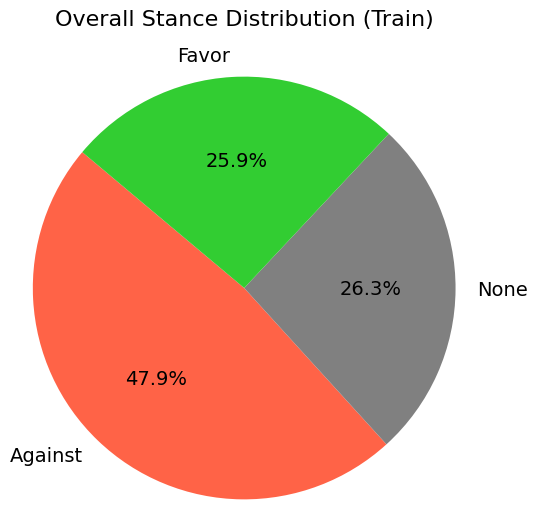

In [8]:
# 5) Descriptive Analysis on cleaned TRAIN data

# --- 5.1) Overall stance pie chart (train split) ---
train_df = df[df.split=="train"]
counts = train_df["label"].value_counts().reindex([1,0,2])
colors = ['#FF6347','#808080','#32CD32']  # Against, None, Favor
labels = ['Against','None','Favor']

plt.figure(figsize=(6,6))
plt.pie(counts,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        textprops={'fontsize':14})
plt.title('Overall Stance Distribution (Train)', fontsize=16, y=1.05)
plt.axis('equal')
plt.show()


# **Descriptive Analysis-Stacked bar**

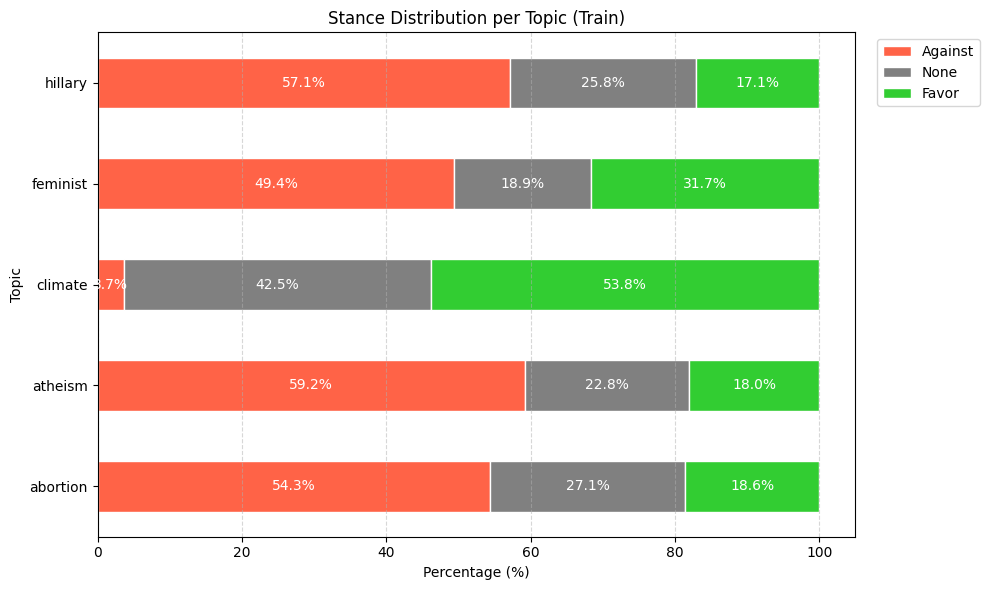

In [9]:
# --- 5.2) Per-topic stacked bar (%), using same color map ---
plot_data = (
    train_df
      .groupby(['topic','label'])
      .size()
      .reset_index(name='count')
      .pivot(index='topic', columns='label', values='count')
      .fillna(0)
)
plot_data = plot_data[[1,0,2]]
plot_pct  = plot_data.div(plot_data.sum(axis=1), axis=0) * 100

ax = plot_pct.plot(kind='barh',
                   stacked=True,
                   figsize=(10,6),
                   color=colors,
                   edgecolor='white')
for patch in ax.patches:
    w = patch.get_width()
    if w>0:
        ax.text(patch.get_x()+w/2,
                patch.get_y()+patch.get_height()/2,
                f'{w:.1f}%',
                ha='center', va='center',
                color='white', fontsize=10)
ax.set_xlabel('Percentage (%)')
ax.set_ylabel('Topic')
ax.set_title('Stance Distribution per Topic (Train)')
plt.legend(labels, bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# **Descriptive Analysis-Word cloud**

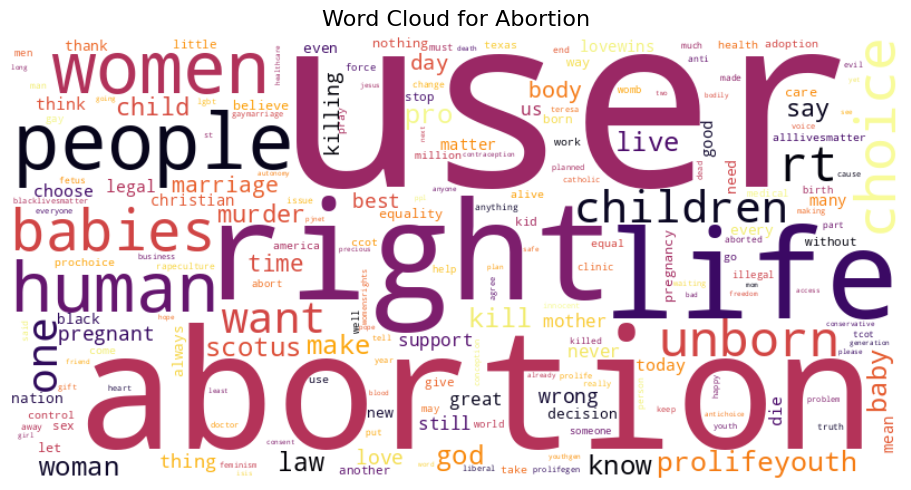

Top 20 words for Abortion:
  user: 305
  abortion: 100
  life: 70
  right: 47
  people: 46
  women: 39
  babies: 35
  unborn: 33
  rt: 32
  human: 31
  children: 31
  choice: 28
  prolifeyouth: 28
  woman: 26
  want: 26
  rights: 25
  scotus: 25
  one: 24
  would: 24
  know: 23
--------------------------------------------------


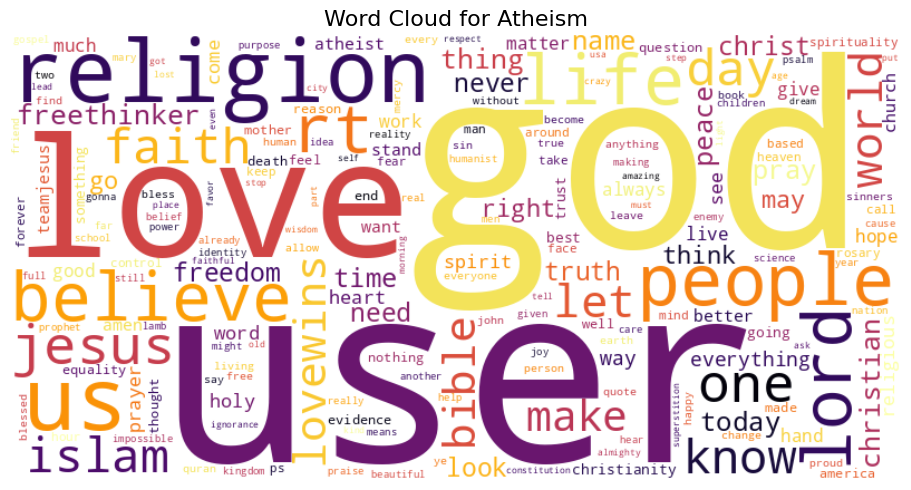

Top 20 words for Atheism:
  god: 145
  user: 142
  love: 40
  us: 31
  people: 30
  life: 28
  lord: 27
  rt: 26
  jesus: 26
  believe: 25
  religion: 25
  faith: 21
  one: 21
  islam: 20
  day: 19
  let: 18
  world: 18
  lovewins: 17
  know: 17
  bible: 17
--------------------------------------------------


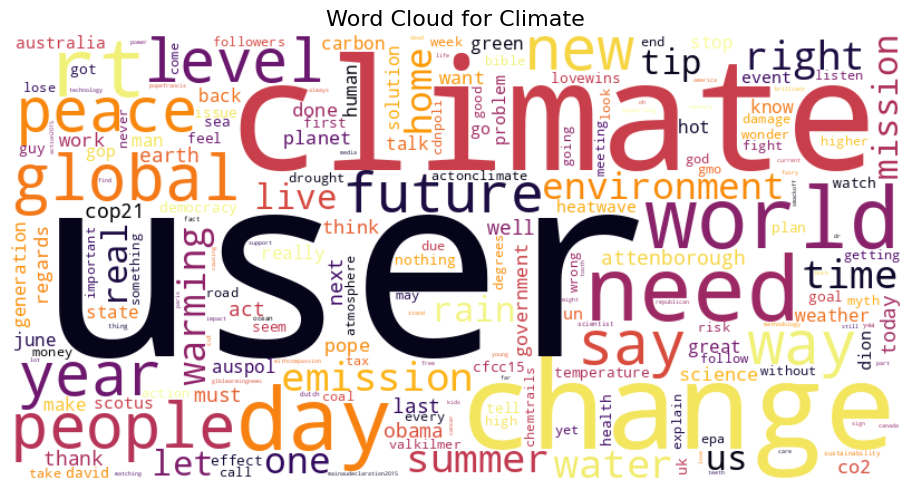

Top 20 words for Climate:
  user: 226
  climate: 44
  change: 36
  like: 15
  world: 15
  rt: 14
  global: 13
  people: 13
  way: 12
  peace: 12
  need: 11
  future: 11
  warming: 10
  environment: 10
  right: 10
  water: 10
  one: 10
  real: 9
  us: 9
  time: 9
--------------------------------------------------


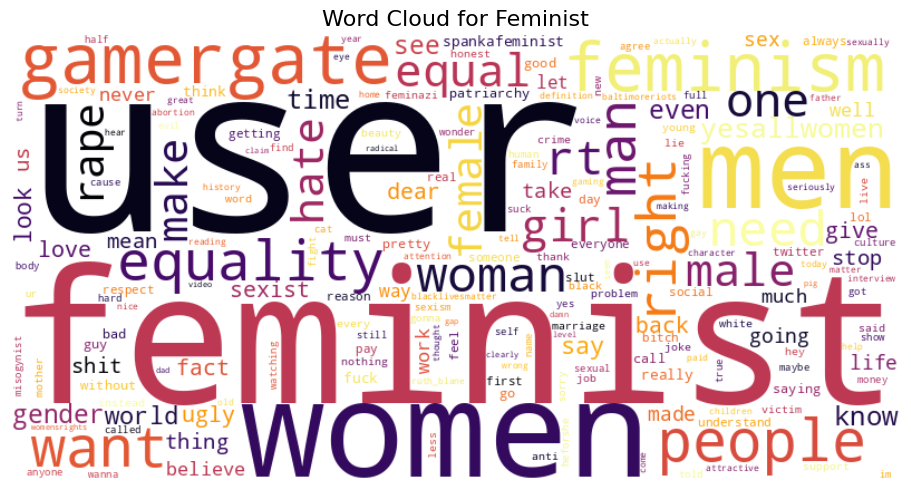

Top 20 words for Feminist:
  user: 296
  women: 104
  feminists: 94
  feminist: 79
  men: 67
  gamergate: 54
  feminism: 50
  like: 43
  people: 36
  equality: 34
  get: 31
  want: 31
  man: 31
  woman: 28
  need: 27
  rt: 26
  equal: 24
  one: 22
  male: 21
  hate: 21
--------------------------------------------------


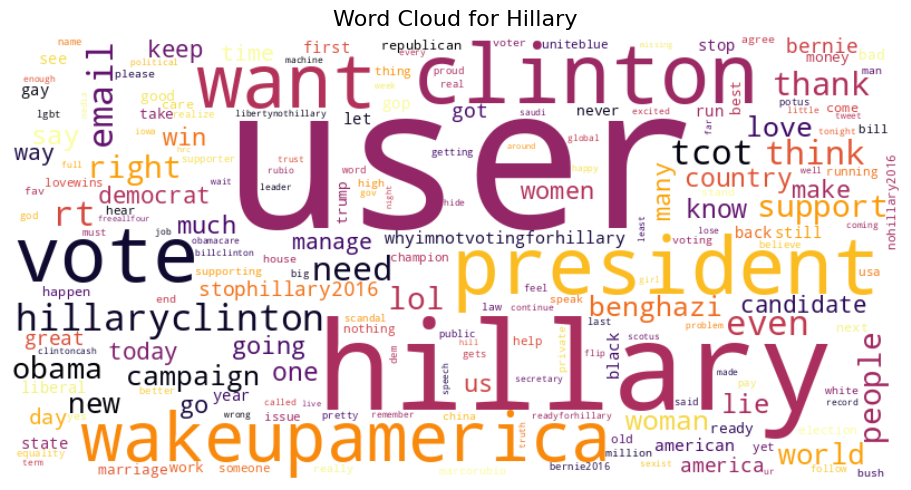

Top 20 words for Hillary:
  user: 609
  hillary: 138
  president: 43
  clinton: 42
  vote: 36
  wakeupamerica: 32
  like: 28
  hillaryclinton: 28
  tcot: 26
  even: 26
  people: 23
  emails: 23
  lol: 23
  think: 23
  obama: 22
  2016: 21
  support: 21
  world: 21
  rt: 21
  benghazi: 19
--------------------------------------------------


In [10]:
# --- 5.3) Word clouds + Top 20 words for each topic ---
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

for topic in TOPICS:
    texts = train_df[train_df.topic==topic]["clean_text"].str.lower().tolist()
    # tokenize by simple split on non-word chars
    tokens = [w for txt in texts for w in re.findall(r'\w+', txt)
              if w not in stop_words and len(w)>1]
    if not tokens:
        continue

    # 5.3a) Word Cloud
    wc = WordCloud(width=800,
                   height=400,
                   background_color='white',
                   colormap='inferno',
                   max_words=200,
                   collocations=False
                  ).generate(' '.join(tokens))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {topic.capitalize()}", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 5.3b) Top 20 words
    print(f"Top 20 words for {topic.capitalize()}:")
    for word, freq in Counter(tokens).most_common(20):
        print(f"  {word}: {freq}")
    print("-" * 50)

# **Descriptive Analysis-Donut Chart**

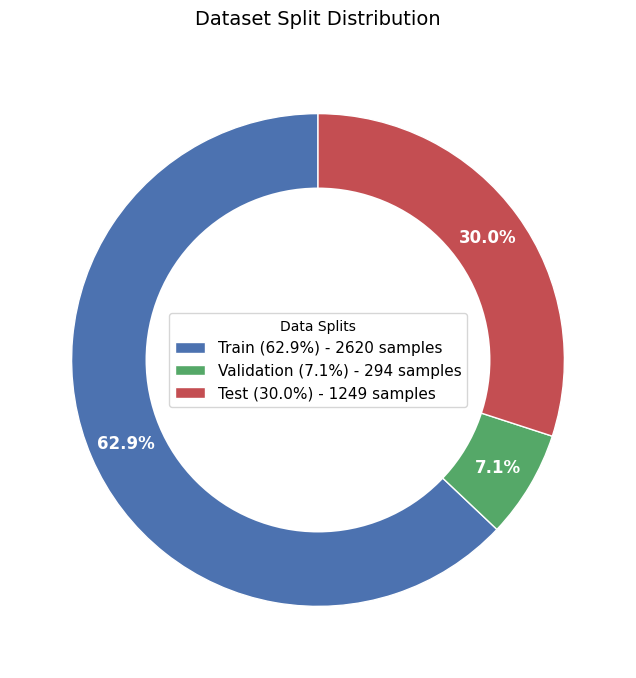

In [11]:
# ───────────────────────────────────────────────────────────────────────
# 5) Split Distribution Visualization
# ───────────────────────────────────────────────────────────────────────
# Calculate split percentages and counts
split_counts = df["split"].value_counts().loc[["train","val","test"]]
total = split_counts.sum()
split_pct = (split_counts / total * 100).round(1)

# Create styled donut plot
plt.figure(figsize=(8, 8))
colors = ["#4C72B0", "#55A868", "#C44E52"]  # Seaborn default colors
wedges, texts, autotexts = plt.pie(
    split_counts,
    labels=None,
    autopct="%.1f%%",
    startangle=90,
    colors=colors,
    pctdistance=0.85,
    wedgeprops={"linewidth": 1, "edgecolor": "white"},
    textprops={"fontsize": 12, "color": "white", "weight": "bold"}
)

# Draw white circle in center to create donut
centre_circle = plt.Circle((0,0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Create custom legend with counts
labels = [
    f"Train ({split_pct['train']}%) - {split_counts['train']} samples",
    f"Validation ({split_pct['val']}%) - {split_counts['val']} samples",
    f"Test ({split_pct['test']}%) - {split_counts['test']} samples"
]
plt.legend(wedges, labels,
           title="Data Splits",
           loc="center",
           bbox_to_anchor=(0.5, 0.5),
           fontsize=11)

# Equal aspect ratio ensures circular shape
plt.title("Dataset Split Distribution", fontsize=14, pad=20)
plt.show()

# **Descriptive Analysis-Bar Plot**

<ipython-input-12-5fd70dce7cc0>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=topic_counts.index,


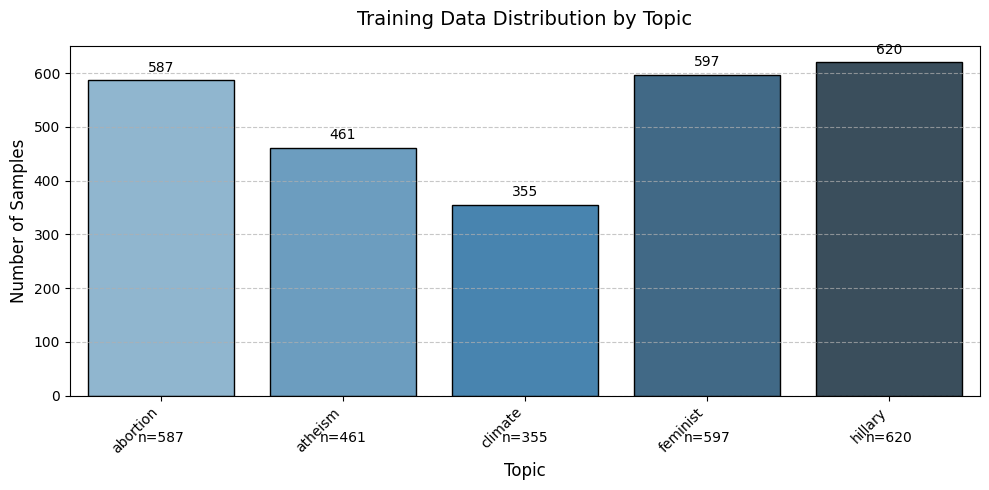

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Assuming train_df is a pandas DataFrame

# Assuming train_df is already loaded and 'topic' column exists
# Assuming TOPICS list is defined and contains the desired order of topics

# Example placeholder data and TOPICS if not available
# Make sure to replace this with your actual data loading
try:
    train_df['topic'].value_counts()
except KeyError:
    print("Creating placeholder data: Make sure you are using your actual train_df and TOPICS list.")
    data = {'topic': ['A']*50 + ['B']*30 + ['C']*70 + ['D']*40 + ['E']*60 + ['F']*20}
    train_df = pd.DataFrame(data)
    TOPICS = ['C', 'A', 'E', 'D', 'B', 'F'] # Example order

# --- Training Data Distribution by Topic ---
# .loc[TOPICS] will ensure the order is maintained and only these topics are included
topic_counts = train_df['topic'].value_counts().loc[TOPICS]

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=topic_counts.index,
                 y=topic_counts.values,
                 palette="Blues_d",
                 edgecolor='black')

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9), # offset points vertically
                textcoords='offset points',
                fontsize=10)

plt.title('Training Data Distribution by Topic', fontsize=14, pad=15)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Corrected data labels below x-axis
# Use a fixed y-offset in axes units (e.g., -0.1 means 10% below the axis bottom)
y_offset_axes_units = -0.1 # Adjust this value as needed
for i, count in enumerate(topic_counts.values): # Iterate through counts using enumerate
    ax.text(i, y_offset_axes_units,
            f'n={count}',
            ha='center', va='top',
            transform=ax.get_xaxis_transform(), # Keep this transform
            fontsize=10) # Use a consistent fontsize

plt.tight_layout() # Should work better now without the massive off-screen element
plt.show()

# **Mean and Median**

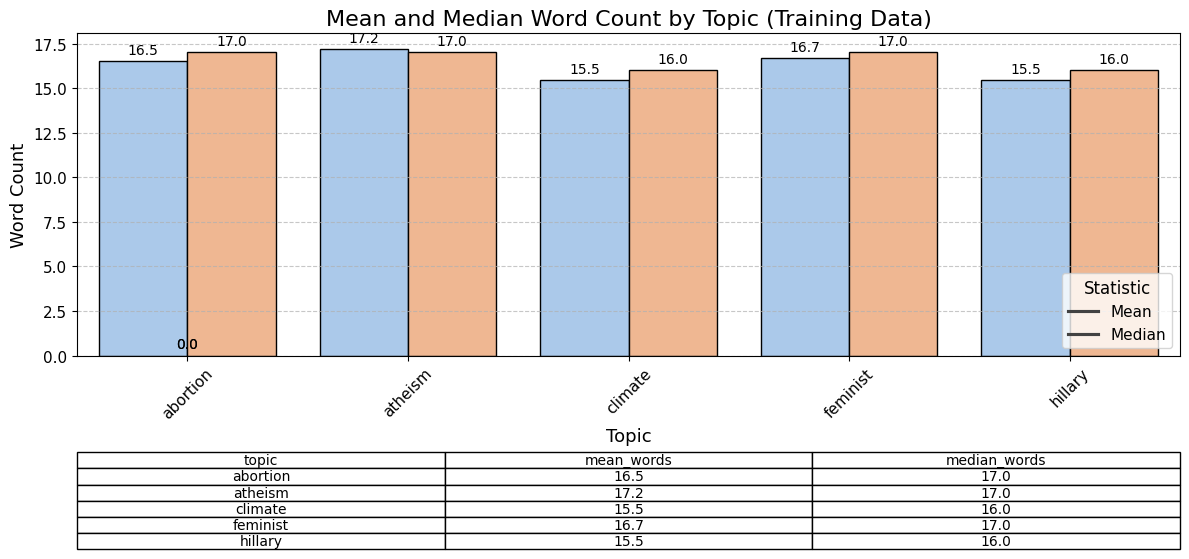

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Text Length Analysis: Mean & Median by Topic ---

# Calculate mean and median word counts
length_stats = (
    train_df.groupby('topic')['clean_text']
    .agg(
        mean_words=lambda x: x.apply(lambda t: len(t.split())).mean(),
        median_words=lambda x: x.apply(lambda t: len(t.split())).median()
    )
    .reset_index()
)

# Melt for plotting
plot_data = length_stats.melt(
    id_vars='topic',
    value_vars=['mean_words', 'median_words'],
    var_name='Statistic',
    value_name='Value'
)

# Create barplot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=plot_data,
    x='topic', y='Value', hue='Statistic',
    palette='pastel', edgecolor='black'
)

# Add value labels
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):
        ax.annotate(f'{height:.1f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 8),
                    textcoords='offset points',
                    fontsize=10)

# Titles and labels
plt.title('Mean and Median Word Count by Topic (Training Data)', fontsize=16)
plt.xlabel('Topic', fontsize=13)
plt.ylabel('Word Count', fontsize=13)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Statistic', labels=['Mean', 'Median'], fontsize=11, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add table
plt.table(
    cellText=length_stats.round(1).values,
    colLabels=length_stats.columns,
    cellLoc='center',
    loc='bottom',
    bbox=[0, -0.6, 1, 0.3],
    fontsize=11
)

plt.tight_layout()
plt.show()


# **Hugging Face DatasetDict**

In [14]:
# ───────────────────────────────────────────────────────────────────────
# 6) Build Hugging Face DatasetDict
# ───────────────────────────────────────────────────────────────────────
def to_hf(subdf):
    return Dataset.from_pandas(subdf[["joint_text","label"]].reset_index(drop=True))

data = DatasetDict({
    "train":      to_hf(df[df.split=="train"]),
    "validation": to_hf(df[df.split=="val"]),
    "test":       to_hf(df[df.split=="test"])
})
print(data, "\n")

DatasetDict({
    train: Dataset({
        features: ['joint_text', 'label'],
        num_rows: 2620
    })
    validation: Dataset({
        features: ['joint_text', 'label'],
        num_rows: 294
    })
    test: Dataset({
        features: ['joint_text', 'label'],
        num_rows: 1249
    })
}) 



# **Tokenization & dynamic padding**

In [15]:

# ───────────────────────────────────────────────────────────────────────
# 7) Tokenization & dynamic padding
# ───────────────────────────────────────────────────────────────────────
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_tokens([f"[{t}]" for t in TOPICS], special_tokens=True)

def tokenize_fn(batch):
    return tokenizer(
        batch["joint_text"],
        truncation=True,
        padding=False,
        max_length=64
    )

data_tok = data.map(tokenize_fn, batched=True)
data_tok = data_tok.rename_column("label", "labels")
data_tok.set_format("torch", columns=["input_ids","attention_mask","labels"])
collator = DataCollatorWithPadding(tokenizer)
print(data_tok)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

Map:   0%|          | 0/2620 [00:00<?, ? examples/s]

Map:   0%|          | 0/294 [00:00<?, ? examples/s]

Map:   0%|          | 0/1249 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['joint_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2620
    })
    validation: Dataset({
        features: ['joint_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 294
    })
    test: Dataset({
        features: ['joint_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1249
    })
})


# **Class-Balanced Loss**

In [16]:
import torch
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights from training data
train_labels = df_raw[df_raw.split=="train"].label.values
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")

# Custom loss function with class weights
class WeightedCELoss(torch.nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights

    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(
            inputs,
            targets,
            reduction="none"
        )
        weights = self.weights[targets]
        return (ce_loss * weights).mean()

# **Model Selection**

In [17]:
# ───────────────────────────────────────────────────────────────────────
# 8) Model
# ───────────────────────────────────────────────────────────────────────

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3
)
model.resize_token_embeddings(len(tokenizer))
model.loss_fct = WeightedCELoss(class_weights)  # Replace default loss

# ────────────────────────
# Hyperparameters (Tuned)
# ────────────────────────

lr = 3e-5           # Learning rate — tuned for stability and performance
batch_size = 64     # Batch size — chosen based on memory and training efficiency
num_epochs = 10     # Number of epochs — enough for convergence without overfitting
weightDecay = 0.1   # Weight decay — regularization to reduce overfitting

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size = batch_size,
    gradient_accumulation_steps = 2,   # Effective batch size of 64
    num_train_epochs = num_epochs,
    weight_decay = weightDecay,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    save_total_limit=2,
    warmup_ratio=0.1,
)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

# **Metrics & Trainer**

In [18]:
# ───────────────────────────────────────────────────────────────────────
# 9) Metrics & Trainer
# ───────────────────────────────────────────────────────────────────────
metric_acc  = evaluate.load("accuracy")
metric_f1   = evaluate.load("f1")
metric_prec = evaluate.load("precision")
metric_rec  = evaluate.load("recall")

def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(axis=-1)

    return {
        "accuracy":  metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "precision": metric_prec.compute(predictions=preds, references=labels,
                                         average="macro")["precision"],
        "recall":    metric_rec.compute(predictions=preds, references=labels,
                                        average="macro")["recall"],
        "f1":        metric_f1.compute(predictions=preds, references=labels,
                                       average="macro")["f1"]
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_tok["train"],
    eval_dataset=data_tok["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


<ipython-input-18-38465c33829a>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# **Train & Final Evaluation**

In [19]:
# ───────────────────────────────────────────────────────────────────────
# 10) Train & Final Evaluation
# ───────────────────────────────────────────────────────────────────────
trainer.train()
test_metrics = trainer.evaluate(data_tok["test"])

print(f"Test Accuracy:   {test_metrics['eval_accuracy']:.4f}")
print(f"Test Precision:  {test_metrics['eval_precision']:.4f}")
print(f"Test Recall:     {test_metrics['eval_recall']:.4f}")
print(f"Test Macro-F1:   {test_metrics['eval_f1']:.4f}")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.056100,1.046205,0.479592,0.159864,0.333333,0.216092
2,0.971700,0.926299,0.564626,0.594236,0.497396,0.506141
3,0.803300,0.777176,0.673469,0.667982,0.632893,0.643223
4,0.636000,0.729099,0.710884,0.691599,0.693239,0.692318
5,0.514900,0.759689,0.697279,0.688476,0.671100,0.674358
6,0.430300,0.759453,0.707483,0.694768,0.696061,0.691224


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy:   0.6581
Test Precision:  0.6152
Test Recall:     0.6404
Test Macro-F1:   0.6251


# **Error Analysis**

<Figure size 600x500 with 0 Axes>

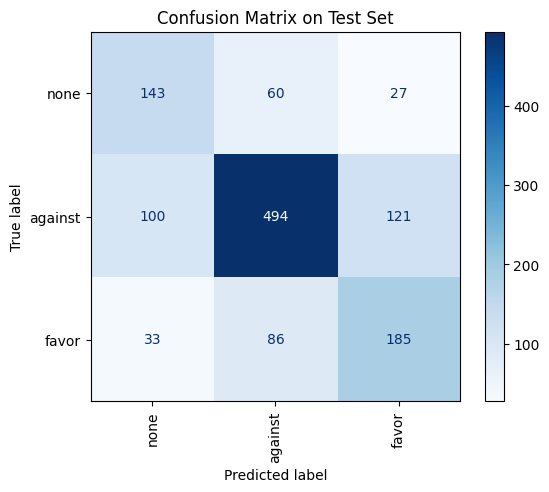


Total against→favor errors: 121

Sample misclassifications (true=against, pred=favor):

— <USER> how many were young women? Were there any black young women?
  True: against → Pred: favor

— Independence Day is a day where men get wasted and dehumanize women by blowing off fireworks! #endJuly4th
  True: against → Pred: favor

— Why would I want to make choices about my own body, when a congressman could do it for me? #ConversationsWithAlex
  True: against → Pred: favor

— Tonight I got called 'the one with the great rack' and I felt empowered because objectification exists for both sexes
  True: against → Pred: favor

— RT <USER> Religions are perfectly happy to peddle an afterlife that doesn't actually exist. #freethinker
  True: against → Pred: favor

Error type counts:
 error_type
other                  74
negation               25
hashtag-heavy          13
rhetorical-question     6
retweet-prefix          3
Name: count, dtype: int64


In [20]:
# 11) Error Analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) Run predictions on the test set
pred_out = trainer.predict(data_tok["test"])
preds    = np.argmax(pred_out.predictions, axis=-1)
labels   = pred_out.label_ids

# 2) Confusion matrix
cm = confusion_matrix(labels, preds, labels=[0,1,2])
disp = ConfusionMatrixDisplay(cm, display_labels=["none","against","favor"])
plt.figure(figsize=(6,5))
disp.plot(cmap="Blues", xticks_rotation="vertical", values_format="d")
plt.title("Confusion Matrix on Test Set")
plt.show()

test_df = pd.DataFrame({
    "text":     tokenizer.batch_decode(data_tok["test"]["input_ids"],
                                       skip_special_tokens=True),
    "true":     labels,
    "pred":     preds
})
label_map = {0:"none", 1:"against", 2:"favor"}
test_df["true_lbl"] = test_df.true.map(label_map)
test_df["pred_lbl"] = test_df.pred.map(label_map)

err = test_df[(test_df.true==1) & (test_df.pred==2)].reset_index(drop=True)
print(f"\nTotal against→favor errors: {len(err)}\n")

print("Sample misclassifications (true=against, pred=favor):\n")
for i, row in err.sample(5, random_state=42).iterrows():
    print(f"— {row.text}\n  True: {row.true_lbl} → Pred: {row.pred_lbl}\n")

def error_type(txt):
    txt_low = txt.lower()
    if txt_low.strip().endswith("?"):
        return "rhetorical-question"
    if re.search(r"\b(no|not|never|don('?|\u2019)t)\b", txt_low):
        return "negation"
    if txt_low.startswith("rt "):
        return "retweet-prefix"
    if "🙄" in txt or "😂" in txt:
        return "sarcasm/emoji"
    if txt.count("#") > 2:
        return "hashtag-heavy"
    if len(txt.split()) > 50:
        return "long-truncation"
    return "other"

err["error_type"] = err.text.apply(error_type)
print("Error type counts:\n", err.error_type.value_counts())